# Introduction
The nice thing about reproducible data analysis (like I'm trying to do here on my blog) is, well, that you can quickly reproduce or even replicated an analysis.

So, in this blog post / notebook, I transfer the analysis of ["Developers' Habits (IntelliJ Edition)"](https://www.feststelltaste.de/developers-habits-intellij-edition/) to another project: The famous open-source operating system Linux. Again, we want to take a look at how much information you can extract from a simple [Git log](https://git-scm.com/docs/git-log) output. This time we want to know

* where the developers come from
* on which weekdays the developers work
* what the normal working hours are and
* if there is any sight of overtime periods.

Because we use an open approach for our analysis, we are able to respond to newly created insights. Again, we use [Pandas](https://pandas.pydata.org/) as data analysis toolkit to accomplish these tasks and execute our code in a [Jypter notebook](http://jupyter.org/) (find the [original on GitHub](https://github.com/feststelltaste/software-analytics/blob/master/notebooks/Developers'%20Habits%20(Linux%20Edition).ipynb)). We also see some refactorings by leveraging more Pandas date functionality as well.

# Gaining the data

I've already described the details on how to get the necessary data in the [https://www.feststelltaste.de/developers-habits-intellij-edition/](previous blog post). What we have at hand is a nice file with the following content:

```
1514531161 -0800	Linus Torvalds	torvalds@linux-foundation.org
1514489303 -0500	David S. Miller	davem@davemloft.net
1514487644 -0800	Tom Herbert	tom@quantonium.net
1514487643 -0800	Tom Herbert	tom@quantonium.net
1514482693 -0500	Willem de Bruijn	willemb@google.com
...
```

It includes the UNIX timestamp (in seconds since epoch), a whitespace, the time zone (where the authors live in), a tab separator, the name of the author, a tab and the email address of the author. The whole log shows 13 years of Linux development that is available on [GitHub repository mirror](https://github.com/torvalds/linux).

# Wrangling the raw data

We import the data by using Pandas' `read_csv` function and the appropriate parameters. We copy only the needed data from the `raw` dataset into the new DataFrame `git_authors`.

In [1]:
import pandas as pd

raw = pd.read_csv(
    r'../../linux/git_timestamp_author_email.log',
    sep="\t",
    encoding="latin-1",
    header=None,
    names=['unix_timestamp', 'author', 'email'])

# create separate columns for time data
raw[['timestamp', 'timezone']] = raw['unix_timestamp'].str.split(" ", expand=True)
# convert timestamp data
raw['timestamp'] = pd.to_datetime(raw['timestamp'], unit="s")
# add hourly offset data
raw['timezone_offset'] = pd.to_numeric(raw['timezone']) / 100.0
# calculate the local time
raw["timestamp_local"] = raw['timestamp'] + pd.to_timedelta(raw['timezone_offset'], unit='h')

# filter out wrong timestamps
raw = raw[
    (raw['timestamp'] >= raw.iloc[-1]['timestamp']) &
    (raw['timestamp'] <= pd.to_datetime('today'))]

git_authors = raw[['timestamp_local', 'timezone', 'author', 'email']].copy()
git_authors.head()

,timestamp_local,timezone,author,email
0,2017-12-31 14:47:43,-0800,Linus Torvalds,torvalds@linux-foundation.org
1,2017-12-31 13:13:56,-0800,Linus Torvalds,torvalds@linux-foundation.org
2,2017-12-31 13:03:05,-0800,Linus Torvalds,torvalds@linux-foundation.org
3,2017-12-31 12:30:34,-0800,Linus Torvalds,torvalds@linux-foundation.org
4,2017-12-31 12:29:02,-0800,Linus Torvalds,torvalds@linux-foundation.org


# Refining the dataset
In this section, we add some additional time-based information to the `DataFrame` to accomplish our tasks.

## Adding weekdays
First, we add the information about the weekdays based on the `dayofweek` information of the `timestamp_local` column. Because we want to preserve the order of the weekdays, we convert the `weekday` entries to a `Categorial` data type, too.

Note: We can do this so easily because we have such a large amount of data so that every weekday will occur. If we can't be sure to have a continuous sequence of weekdays, we have to use something like the `pd.Grouper` method to fill in missing weekdays.

In [2]:
import calendar

git_authors['weekday'] = git_authors["timestamp_local"].dt.weekday_name
git_authors['weekday'] = pd.Categorical(git_authors['weekday'], categories=calendar.day_name, ordered=True)
git_authors.head()

,timestamp_local,timezone,author,email,weekday
0,2017-12-31 14:47:43,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday
1,2017-12-31 13:13:56,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday
2,2017-12-31 13:03:05,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday
3,2017-12-31 12:30:34,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday
4,2017-12-31 12:29:02,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday


## Adding working hours
For the working hour analysis, we extract the hour information from the `timestamp_local` columns. Note: Again, we assume that every hour is in the dataset.

In [3]:
git_authors['hour'] = git_authors['timestamp_local'].dt.hour
git_authors.head()

,timestamp_local,timezone,author,email,weekday,hour
0,2017-12-31 14:47:43,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday,14
1,2017-12-31 13:13:56,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday,13
2,2017-12-31 13:03:05,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday,13
3,2017-12-31 12:30:34,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday,12
4,2017-12-31 12:29:02,-0800,Linus Torvalds,torvalds@linux-foundation.org,Sunday,12


# Analyzing the data
With the prepared `git_authors` DataFrame, we are now able to deliver insights into the past years of development.

## Developers' timezones
First, we want to know where the developers roughly live. For this, we plot the values of the `timezone` columns as a pie chart.

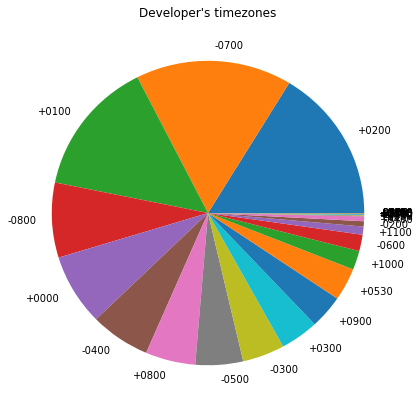

In [4]:
%matplotlib inline
timezones = git_authors['timezone'].value_counts()
timezones.plot(kind='pie', figsize=(7,7), title="Developer's timezones", label="")

**Result**

The majority of the developers' commit from the time zones +0100, +0200 and -0700. With most commits coming probably from the West Coast of the USA, this might just be an indicator that [Linus Torvalds](https://en.wikipedia.org/wiki/Linus_Torvalds) lives there ;-) . But there are also many commits from developers within Western Europe.

## Weekdays with the most commits

Next, we want to know on which days the developers are working during the week. We count by the weekdays but avoid sorting the results to keep the order along our categories.

In [5]:
commits_per_weekday = git_authors['weekday'].value_counts(sort=False)
commits_per_weekday

Monday       124296
Tuesday      131690
Wednesday    131019
Thursday     127097
Friday       117635
Saturday      44877
Sunday        46600
Name: weekday, dtype: int64

We plot the result as a standard bar chart.

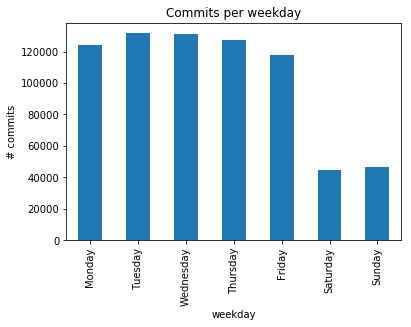

In [6]:
ax = commits_per_weekday.plot(kind='bar', title="Commits per weekday")
ax.set_xlabel('weekday')
ax.set_ylabel('# commits')

**Result:** 

Most of the commits occur during normal working days with a slight peak on Wednesday. There are relative few commits happening on weekends.

## Working behavior of the main contributor
It would be very interesting and easy to see when Linus Torvalds (the main contributor to Linux) is working. But we won't do that because the yet unwritten codex of Software Analytics does tell us that it's not OK to analyze the behaviour of a single person's based on such uncleaned data as we have it here.

## Usual working hours
To find out about the working habits of the contributors, we group the commits by `hour` and count the entries (in this case we choose `author`) to see if there are any irregularities.

In [7]:
working_hours = git_authors.groupby(['hour'])['author'].count()
working_hours.head()

hour
0    19533
1    15044
2    10420
3     7000
4     6068
Name: author, dtype: int64

Again, we plot the results with a standard bar chart.

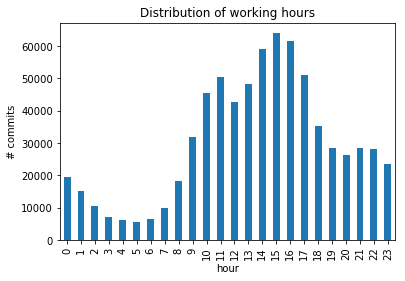

In [8]:
ax = working_hours.plot(kind='bar')
ax.set_title("Distribution of working hours")
ax.yaxis.set_label_text("# commits")
ax.xaxis.set_label_text("hour")

**Result**

The distribution of the working hours is really interesting one. First, you can clearly see that there is a dent around 12:00. So this might be an indicator that developers have lunch at regular times (which is a good thing IMHO). Another not so typical result is the slight rise after 20:00. This could be interpreted as the development activity of free-time developers that code for Linux after their day-time job. Nevertheless, most of the developers seem to get a decent amount of sleep indicated by low commit activity from 1:00 to 7:00 :-D

## Signs of overtime 

At last, we have a look at possible overtime periods by creating a little model. We first group all commits on a weekly basis per authors. As grouping function, we choose `max()` to get the hour where each author committed at latest per week.

In [9]:
latest_hour_per_week  = git_authors.groupby(
    [
        pd.Grouper(key='timestamp_local', freq='1w'), 
        'author']
)[['hour']].max()

latest_hour_per_week.head()

hour
timestamp_local author                
2005-04-17      Adrian Bunk         15
                Alexander Nyberg    15
                Andi Kleen          15
                Andrea Arcangeli    15
                Andrew Vasquez      15

Next, we want to know if there were any stressful time periods that forced the developers to work overtime over a longer period of time. We calculate the mean of all late stays of all authors for each week.

In [10]:
mean_latest_hours_per_week = \
    latest_hour_per_week \
    .reset_index().groupby('timestamp_local').mean()
mean_latest_hours_per_week.head()

,hour
timestamp_local,
2005-04-17,14.956522
2005-04-24,16.494382
2005-05-01,12.349398
2005-05-08,15.979798
2005-05-15,15.984127


We also create a trend line that shows how the contributors are working over the span of the past years. We use the `polyfit` function from `numpy` for this which needs a numeric index to calculate the polynomial coefficients later on. 

We then calculate the coeffiecients with a three-dimensional polynomial based on the hours of the `mean_latest_hours_per_week` DataFrame. For visualization, we decrease the number of degrees and calculate the y-coordinates for all weeks that are encoded in `numeric_index`.

In [11]:
import numpy as np

numeric_index = range(0, len(mean_latest_hours_per_week))
coefficients = np.polyfit(numeric_index, mean_latest_hours_per_week.hour, 3)
polynomial = np.poly1d(coefficients)
ys = polynomial(numeric_index)
ys[:5]

array([ 14.74298901,  14.74384165,  14.74469374,  14.74554526,  14.74639619])

At last, we plot the results of the `mean_latest_hours_per_week` DataFrame as well as the trend line in one line plot.

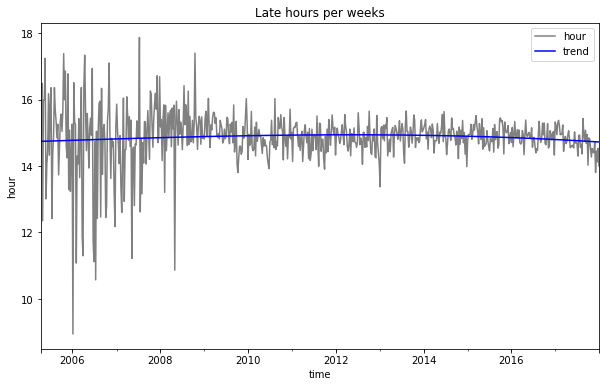

In [12]:
mean_latest_hours_per_week['trend'] = ys
mean_latest_hours_per_week
ax = mean_latest_hours_per_week[['hour', 'trend']].plot(
    figsize=(10, 6), color=['grey','blue'], title="Late hours per weeks")
ax.set_xlabel("time")
ax.set_ylabel("hour")

**Result**

We see no sign of significant over time periods over 13 years of Linux development. After the migration to the Git repository, there might have been a time with some irregularities. But overall, there are no signs of death marches. It seems that the Linux development team has a stable development process.

# Closing remarks

Again, we've seen that various metrics and results can be easily created from a simple Git log output file. With Pandas, it's possible to get to know the habits of the developers of software projects. Thanks to Jupyter's open notebook approach, we can easily adapt existing analysis and add situation specific information to it as we go.